In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
import findspark
findspark.init(r"C:\python311\Lib\site-packages\pyspark")

In [2]:
def generate_mlp_data(n_samples=200, seed=42):
    """
    Generate synthetic 2D classification data using NumPy.
    Returns: X (features), y (labels)
    """
    np.random.seed(seed)
    X = np.random.randn(n_samples, 2)
    # Simple rule for labels: circle vs outside
    y = (X[:,0]**2 + X[:,1]**2 < 1.5).astype(int)
    return X, y

In [3]:
def train_pyspark_mlp_model(X, y):
    """
    Train a PySpark Multilayer Perceptron model on the dataset.
    Uses PySpark modules only.
    """
    spark = SparkSession.builder.appName("MLPModel").getOrCreate()

    # Convert NumPy arrays into Spark DataFrame
    data = [(float(X[i,0]), float(X[i,1]), int(y[i])) for i in range(len(y))]
    df = spark.createDataFrame(data, ["f1", "f2", "label"])

    # Assemble features
    assembler = VectorAssembler(inputCols=["f1", "f2"], outputCol="features")
    df_features = assembler.transform(df)

    # Define MLP layers: input=2, hidden=5, output=2 classes
    layers = [2, 5, 2]

    # Train MLP classifier
    mlp = MultilayerPerceptronClassifier(
        featuresCol="features",
        labelCol="label",
        predictionCol="prediction",
        maxIter=100,
        layers=layers,
        blockSize=128,
        seed=1234
    )
    model = mlp.fit(df_features)

    # Predictions
    predictions_df = model.transform(df_features).toPandas()
    predictions = predictions_df["prediction"].values

    # Plot results
    plot_mlp_results(X, y, predictions)

    return model



In [4]:
def plot_mlp_results(X, y, predictions):
    """
    Plot the dataset and the PySpark MLP predictions.
    """
    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', label="True Labels")
    plt.scatter(X[:,0], X[:,1], c=predictions, cmap=plt.cm.Paired, alpha=0.3, marker='x', label="Predictions")
    plt.title("Synthetic Data with PySpark MLP Classifier")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

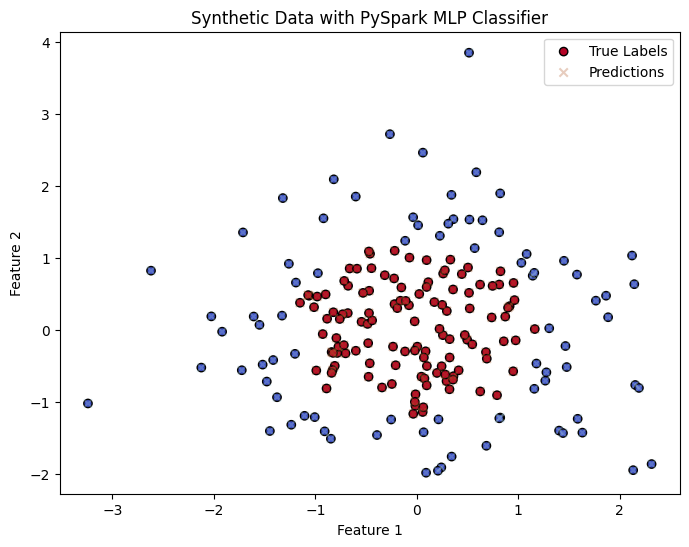

In [5]:
X, y = generate_mlp_data()
model = train_pyspark_mlp_model(X, y)